Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Fooling Feature Visualizations Through a Fooling Circuit

## Imports

In [28]:
! pip install git+https://github.com/rgeirhos/lucent.git

  Cloning https://github.com/rgeirhos/lucent.git to /tmp/pip-req-build-orbulrbw
  Running command git clone --filter=blob:none --quiet https://github.com/rgeirhos/lucent.git /tmp/pip-req-build-orbulrbw
  Resolved https://github.com/rgeirhos/lucent.git to commit c1b242bc8a6d9b201bfa8710b5579a2930ce6313
  Preparing metadata (setup.py) ... done


In [29]:
import os
import numpy as np
import imageio
from skimage.transform import resize
import matplotlib.pyplot as plt
from collections import OrderedDict
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as T

from lucent.optvis.transform import standard_transforms
from lucent.optvis import render, param

In [60]:
PROJECT_DIR = '../'
CLASSIFIER_WEIGHT_NAME = 'fooling_classifier_backup.pt'

## Function definitions

In [31]:
def convert_rendered_img_to_numpy(img):
    x = np.squeeze(img[0]*255.0).astype(np.uint8)
    assert np.min(x) >= 0
    assert np.max(x) <= 255
    return x

In [32]:
def center_crop(h, w):
    def inner(x: torch.Tensor) -> torch.Tensor:
        assert len(x.shape) ==4, print(x.shape, type(x))
        assert x.shape[2] >= h, print(x.shape, type(x))
        assert x.shape[3] >= w, print(x.shape, type(x))

        oy = (x.shape[2] - h) // 2
        ox = (x.shape[3] - w) // 2

        return x[:, :, oy:oy+h, ox:ox+w]

    return inner

In [33]:
def visualize(model, idx, show_inline=True, thresholds=(512,), *args, **kwargs):
    #img_size = 224
    #img = render.render_vis(model, idx,
    #                       show_inline=show_inline, thresholds=thresholds,
    #                       param_f=lambda: param.image(img_size, batch=1),
    #                       transforms=standard_transforms +
    #                       [center_crop(img_size, img_size)], *args, **kwargs)
    img_size = 128
    img = render.render_vis(model, idx,
                           show_inline=show_inline, thresholds=thresholds,
                           param_f=lambda: param.image(img_size, batch=1),
                           transforms=standard_transforms + [center_crop(img_size, img_size)],
                           preprocess=False, *args, **kwargs)
    return img

In [34]:
def save_multiple_visualizations(dir_path, model, model_name, viz_indices,
                                 thresholds=(512,), *args, **kwargs):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    for idx in viz_indices:

        images = visualize(model, idx, thresholds=thresholds, *args, **kwargs)
        assert len(images) == len(thresholds)

        for i, img in enumerate(images):
            img_numpy = convert_rendered_img_to_numpy(img)
            imageio.imwrite(os.path.join(dir_path, f"{model_name}_layer-{idx}_threshold-{thresholds[i]}.png"), img_numpy)

In [35]:
def load_image(img_path=os.path.join(PROJECT_DIR, 'assets/brutus.jpg'), transform=lambda x: x/255.0):

    img = T.Resize((224, 224))(Image.open(img_path))
    img = transform(np.asarray(img, dtype='float'))
    img = np.transpose(img, (2, 0, 1))

    print(f"Loaded image of shape {img.shape} with min {np.min(img)} and max {np.max(img)}.")

    return img

In [36]:
def load_classifier_weights(model,
                            weight_dir=os.path.join(PROJECT_DIR, 'assets'),
                            weight_name=CLASSIFIER_WEIGHT_NAME):
    """Load classifier weights into existing model's weights"""

    weight_path = os.path.join(weight_dir, weight_name)

    # preprocess classifier_state_dict
    classifier_prelim_state_dict = torch.load(weight_path, map_location=torch.device('cpu'))
    classifier_state_dict = {"classifier."+k.replace('module.', ''): v for k, v in classifier_prelim_state_dict.items()}

    # remove classifier from original dict
    original_state_dict_with_classifier = model.state_dict()
    original_state_dict = {k: v for k, v in original_state_dict_with_classifier.items() if "classifier." not in k}

    # make sure dicts are different
    a = set(original_state_dict.keys())
    b = set(classifier_state_dict.keys())
    assert len(a.intersection(b)) == 0, f"matching keys found: {a.intersection(b)}"

    # combine dicts
    original_state_dict.update(classifier_state_dict)
    print(model.load_state_dict(original_state_dict, strict=False))

In [37]:
def manually_set_weights(model, class_offset=100, num_classes=1000,
                         orig_last_layer_num_units=1008):
    """Set weights such that last layer visualizations will be offset by an arbitrary constant."""

    k = 250.0

    with torch.no_grad():

        # weights
        layer_1_num_units = 1000
        model.lyr_1.weight = torch.nn.Parameter(torch.Tensor(np.zeros([layer_1_num_units,orig_last_layer_num_units])))
        for i in range(num_classes):
            model.lyr_1.weight[i,i] = 1.0

        model.lyr_2.weight = torch.nn.Parameter(torch.Tensor(np.zeros([2000, 1001])))
        for i in range(num_classes):
            model.lyr_2.weight[i,i] = 1.0
            model.lyr_2.weight[i+num_classes, (i + class_offset)%num_classes] = 1.0

            model.lyr_2.weight[i, num_classes] = - k
            model.lyr_2.weight[i+num_classes, num_classes] = k

        model.lyr_3.weight = torch.nn.Parameter(torch.Tensor(np.zeros([1000, 2000])))
        for i in range(num_classes):
            model.lyr_3.weight[i,i] = 1.0
            model.lyr_3.weight[i,i+num_classes] = 1.0

        # biases
        model.lyr_1.bias = torch.nn.Parameter(torch.Tensor(np.zeros([layer_1_num_units])))
        model.lyr_1.bias[0:num_classes] = 100.0

        model.lyr_2.bias = torch.nn.Parameter(torch.Tensor(np.zeros([2000])))
        model.lyr_2.bias[0:num_classes] = 0.0
        model.lyr_2.bias[num_classes:(2*num_classes)] = - k

        model.lyr_3.bias = torch.nn.Parameter(torch.Tensor(np.zeros([num_classes])))

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device).eval();
    print(f"Manually setting weights completed with class_offset {class_offset}.")

In [38]:
def manually_specify_visualization_weights(model, input_size=224):
    """Set weights such that last layer visualizations will show a target image."""

    image = load_image()
    print(image.shape)

    with torch.no_grad():

        class_offset = 100
        num_classes = 1000
        k = 250

        # weights
        layer_1_num_units = 1000
        model.lyr_1.weight = torch.nn.Parameter(torch.Tensor(np.zeros([layer_1_num_units, 1008])))
        for i in range(num_classes):
            model.lyr_1.weight[i,i] = 1.0

        model.lyr_2.weight = torch.nn.Parameter(torch.Tensor(np.zeros([2000, 1002])))
        for i in range(num_classes):
            model.lyr_2.weight[i,i] = 1.0
            model.lyr_2.weight[i+num_classes, 1001] = 1.0

            model.lyr_2.weight[i, num_classes] = - k
            model.lyr_2.weight[i+num_classes, num_classes] = k

        model.lyr_3.weight = torch.nn.Parameter(torch.Tensor(np.zeros([1000, 2000])))
        for i in range(num_classes):
            model.lyr_3.weight[i,i] = 1.0
            model.lyr_3.weight[i,i+num_classes] = 1.0

        # biases
        model.lyr_1.bias = torch.nn.Parameter(torch.Tensor(np.zeros([layer_1_num_units])))
        model.lyr_1.bias[0:num_classes] = 100.0

        model.lyr_2.bias = torch.nn.Parameter(torch.Tensor(np.zeros([2000])))
        model.lyr_2.bias[0:num_classes] = 0.0
        model.lyr_2.bias[num_classes:(2*num_classes)] = - k

        model.lyr_3.bias = torch.nn.Parameter(torch.Tensor(np.zeros([num_classes])))

        model.viz_layer.weight = torch.nn.Parameter(torch.Tensor(np.zeros([1, 3, 224, 224]) - 0.1))
        for c in range(3):
            for i in range(input_size):
                for j in range(input_size):
                    # dividing by input_size**2 ensures that the layer activations don't explode during visualization
                    model.viz_layer.weight[0,c,i,j] = image[c,i,j]/(input_size**2)

    model.to(device).eval();


## Figure: visualization-trajectory

In [39]:
from lucent.modelzoo.inceptionv1.InceptionV1 import InceptionV1 as INCEPTION_V1
model = INCEPTION_V1(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device).eval();

In [40]:
dir_path = os.path.join(PROJECT_DIR, 'data/visualization-trajectory/')

  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 512/512 [00:28<00:00, 17.69it/s]



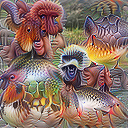

In [41]:
save_multiple_visualizations(dir_path=dir_path,
                             model=model,
                             model_name="inception-v1-unmodified",
                             viz_indices=[f"softmax2_pre_activation_matmul:0" for x in [0]],
                             thresholds=(1, 2, 4, 8, 16, 32, 64, 128, 256, 512))

## Figure: permuted-visualizations-offset-100

In [42]:
from lucent.modelzoo.inceptionv1.InceptionV3 import InceptionV3 as INCEPTION_V3
model = INCEPTION_V3(pretrained=True, add_custom_layers=True,
                     use_RELU_in_custom_layers=True, verbose=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device).eval();
assert type(model.classifier) is not None

cuda:0


In [43]:
load_classifier_weights(model)

<All keys matched successfully>


In [44]:
manually_set_weights(model=model, class_offset=100, num_classes=1000)

Manually setting weights completed with class_offset 100.


In [45]:
dir_path = os.path.join(PROJECT_DIR, 'data/permuted-visualizations-offset-100/')

  0%|          | 0/512 [00:00<?, ?it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  0%|          | 1/512 [00:00<02:06,  4.05it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  0%|          | 2/512 [00:00<02:18,  3.69it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 3/512 [00:00<02:09,  3.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 4/512 [00:01<02:10,  3.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 5/512 [00:01<02:13,  3.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 6/512 [00:01<02:13,  3.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|▏         | 7/512 [00:01<02:12,  3.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 8/512 [00:02<02:15,  3.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 9/512 [00:02<02:16,  3.69it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 10/512 [00:02<02:14,  3.74it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 11/512 [00:02<02:13,  3.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 12/512 [00:03<02:13,  3.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 13/512 [00:03<02:11,  3.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 15/512 [00:03<02:09,  3.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 17/512 [00:04<01:53,  4.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 18/512 [00:04<01:57,  4.21it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 19/512 [00:04<02:01,  4.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 21/512 [00:05<02:01,  4.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 22/512 [00:05<02:06,  3.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 23/512 [00:05<02:02,  3.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 24/512 [00:06<02:05,  3.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 25/512 [00:06<02:09,  3.76it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 26/512 [00:06<02:10,  3.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 28/512 [00:07<01:49,  4.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 34/512 [00:07<00:51,  9.27it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 36/512 [00:07<00:51,  9.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 40/512 [00:08<00:52,  8.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 41/512 [00:08<00:52,  8.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 48/512 [00:08<00:26, 17.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 11%|█         | 56/512 [00:08<00:17, 26.17it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 12%|█▎        | 64/512 [00:09<00:14, 30.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 14%|█▍        | 72/512 [00:09<00:12, 33.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 16%|█▌        | 80/512 [00:09<00:12, 35.18it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 16%|█▋        | 84/512 [00:09<00:12, 35.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 18%|█▊        | 92/512 [00:10<00:21, 19.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 20%|█▉        | 100/512 [00:10<00:16, 24.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 20%|██        | 104/512 [00:10<00:15, 26.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 22%|██▏       | 112/512 [00:10<00:14, 28.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 23%|██▎       | 120/512 [00:11<00:12, 30.28it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 25%|██▌       | 128/512 [00:11<00:12, 31.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 26%|██▌       | 132/512 [00:11<00:11, 33.06it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 27%|██▋       | 140/512 [00:11<00:10, 34.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 29%|██▉       | 148/512 [00:11<00:10, 35.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 30%|███       | 156/512 [00:12<00:09, 35.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 32%|███▏      | 164/512 [00:12<00:09, 36.06it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 34%|███▎      | 172/512 [00:12<00:09, 36.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 35%|███▌      | 180/512 [00:12<00:09, 36.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 37%|███▋      | 188/512 [00:13<00:08, 36.53it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 38%|███▊      | 196/512 [00:13<00:08, 36.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 40%|███▉      | 204/512 [00:13<00:08, 35.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 41%|████▏     | 212/512 [00:13<00:08, 36.02it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 43%|████▎     | 220/512 [00:13<00:08, 36.32it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▍     | 228/512 [00:14<00:07, 36.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 236/512 [00:14<00:07, 36.06it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 244/512 [00:14<00:07, 36.62it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 252/512 [00:14<00:07, 36.53it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 260/512 [00:15<00:07, 35.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 264/512 [00:15<00:07, 34.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 268/512 [00:15<00:14, 16.35it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 271/512 [00:16<00:26,  9.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 273/512 [00:17<00:33,  7.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▎    | 275/512 [00:17<00:38,  6.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 278/512 [00:18<00:45,  5.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 279/512 [00:18<00:49,  4.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▍    | 281/512 [00:19<00:52,  4.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 283/512 [00:19<00:55,  4.15it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 284/512 [00:19<00:57,  3.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 286/512 [00:20<00:56,  3.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 287/512 [00:20<00:58,  3.84it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▋    | 288/512 [00:20<00:58,  3.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▋    | 289/512 [00:21<00:57,  3.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 290/512 [00:21<00:56,  3.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 291/512 [00:21<00:56,  3.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 292/512 [00:22<00:57,  3.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 293/512 [00:22<00:57,  3.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 294/512 [00:22<00:56,  3.84it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 297/512 [00:22<00:37,  5.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▊    | 300/512 [00:23<00:28,  7.35it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▉    | 302/512 [00:23<00:26,  8.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▉    | 304/512 [00:23<00:24,  8.56it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 306/512 [00:23<00:23,  8.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 307/512 [00:24<00:24,  8.40it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 61%|██████▏   | 314/512 [00:24<00:09, 20.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 63%|██████▎   | 322/512 [00:24<00:06, 27.62it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 64%|██████▍   | 330/512 [00:24<00:05, 31.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 66%|██████▌   | 338/512 [00:24<00:05, 34.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 68%|██████▊   | 346/512 [00:25<00:04, 35.24it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 69%|██████▉   | 354/512 [00:25<00:04, 36.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 71%|███████   | 362/512 [00:25<00:04, 36.33it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 72%|███████▏  | 370/512 [00:25<00:03, 36.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 74%|███████▍  | 378/512 [00:26<00:03, 36.17it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 75%|███████▌  | 386/512 [00:26<00:03, 36.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 77%|███████▋  | 394/512 [00:26<00:03, 36.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 79%|███████▊  | 402/512 [00:26<00:02, 36.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 80%|████████  | 410/512 [00:26<00:02, 34.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 82%|████████▏ | 418/512 [00:27<00:02, 34.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 83%|████████▎ | 426/512 [00:27<00:02, 35.49it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 85%|████████▍ | 434/512 [00:27<00:02, 35.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 86%|████████▋ | 442/512 [00:27<00:01, 36.18it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 88%|████████▊ | 450/512 [00:28<00:01, 36.35it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 89%|████████▉ | 458/512 [00:28<00:01, 36.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 91%|█████████ | 466/512 [00:28<00:01, 36.54it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 474/512 [00:28<00:01, 36.48it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 482/512 [00:28<00:00, 34.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 490/512 [00:29<00:00, 35.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 498/512 [00:29<00:00, 36.32it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 506/512 [00:29<00:00, 36.18it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|██████████| 512/512 [00:29<00:00, 17.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]



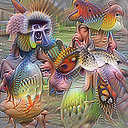

  1%|          | 4/512 [00:00<00:15, 33.14it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 8/512 [00:00<00:16, 30.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 12/512 [00:01<01:06,  7.51it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 14/512 [00:01<01:23,  5.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 16/512 [00:02<01:34,  5.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 18/512 [00:02<01:44,  4.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 19/512 [00:03<01:50,  4.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 20/512 [00:03<01:54,  4.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 21/512 [00:03<01:56,  4.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 22/512 [00:03<02:02,  4.00it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 23/512 [00:04<01:59,  4.08it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 24/512 [00:04<02:02,  3.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 26/512 [00:04<02:01,  3.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 27/512 [00:05<02:05,  3.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 28/512 [00:05<02:04,  3.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 29/512 [00:05<02:03,  3.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 31/512 [00:06<02:01,  3.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▋         | 32/512 [00:06<02:04,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▋         | 33/512 [00:06<02:03,  3.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 34/512 [00:06<02:04,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 36/512 [00:07<02:02,  3.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 41/512 [00:07<00:59,  7.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 42/512 [00:08<00:57,  8.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 45/512 [00:08<00:54,  8.55it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 47/512 [00:08<00:52,  8.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 10%|▉         | 49/512 [00:08<00:51,  8.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 10%|▉         | 51/512 [00:09<00:52,  8.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 11%|█         | 55/512 [00:09<00:28, 16.06it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 12%|█▏        | 63/512 [00:09<00:17, 26.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 14%|█▍        | 71/512 [00:09<00:14, 31.17it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 15%|█▌        | 79/512 [00:09<00:12, 34.05it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 17%|█▋        | 87/512 [00:10<00:11, 35.49it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 19%|█▊        | 95/512 [00:10<00:11, 36.10it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 20%|██        | 103/512 [00:10<00:19, 21.38it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 21%|██▏       | 110/512 [00:11<00:16, 24.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 23%|██▎       | 118/512 [00:11<00:13, 28.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 24%|██▍       | 122/512 [00:11<00:13, 29.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 25%|██▌       | 130/512 [00:11<00:11, 31.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 27%|██▋       | 138/512 [00:11<00:11, 32.08it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 29%|██▊       | 146/512 [00:12<00:10, 33.69it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 30%|███       | 154/512 [00:12<00:10, 34.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 32%|███▏      | 162/512 [00:12<00:09, 35.24it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 33%|███▎      | 170/512 [00:12<00:09, 35.70it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 35%|███▍      | 178/512 [00:13<00:09, 36.00it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 36%|███▋      | 186/512 [00:13<00:09, 35.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 38%|███▊      | 194/512 [00:13<00:08, 35.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 39%|███▉      | 202/512 [00:13<00:08, 36.35it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 41%|████      | 210/512 [00:13<00:08, 36.12it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 43%|████▎     | 218/512 [00:14<00:08, 36.53it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▍     | 226/512 [00:14<00:07, 36.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 234/512 [00:14<00:07, 36.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 242/512 [00:14<00:07, 36.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 250/512 [00:15<00:07, 35.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|█████     | 258/512 [00:15<00:07, 36.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 266/512 [00:15<00:07, 34.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 270/512 [00:16<00:16, 14.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 273/512 [00:16<00:27,  8.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▎    | 275/512 [00:17<00:33,  7.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 277/512 [00:17<00:38,  6.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 279/512 [00:18<00:43,  5.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▍    | 280/512 [00:18<00:45,  5.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▍    | 281/512 [00:18<00:47,  4.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 282/512 [00:19<00:49,  4.62it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 283/512 [00:19<00:52,  4.35it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 284/512 [00:19<00:54,  4.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 285/512 [00:20<00:55,  4.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 286/512 [00:20<00:57,  3.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 287/512 [00:20<00:56,  4.00it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▋    | 289/512 [00:21<00:55,  4.05it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 290/512 [00:21<00:55,  4.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 291/512 [00:21<00:57,  3.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 293/512 [00:22<00:55,  3.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 294/512 [00:22<00:57,  3.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 295/512 [00:22<00:57,  3.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 297/512 [00:23<00:49,  4.34it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 299/512 [00:23<00:34,  6.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▉    | 302/512 [00:23<00:28,  7.39it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▉    | 304/512 [00:23<00:25,  8.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 306/512 [00:24<00:24,  8.54it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|██████    | 308/512 [00:24<00:23,  8.55it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 61%|██████    | 313/512 [00:24<00:11, 16.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 317/512 [00:24<00:08, 22.54it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 63%|██████▎   | 325/512 [00:24<00:06, 29.64it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 65%|██████▌   | 333/512 [00:25<00:05, 32.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 67%|██████▋   | 341/512 [00:25<00:04, 34.50it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 68%|██████▊   | 349/512 [00:25<00:04, 35.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 70%|███████   | 360/512 [00:26<00:06, 23.84it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 71%|███████   | 364/512 [00:26<00:05, 26.27it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 73%|███████▎  | 372/512 [00:26<00:04, 30.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 74%|███████▍  | 380/512 [00:26<00:04, 32.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 76%|███████▌  | 388/512 [00:26<00:03, 34.34it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 77%|███████▋  | 396/512 [00:27<00:03, 35.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 79%|███████▉  | 404/512 [00:27<00:03, 35.66it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 80%|████████  | 412/512 [00:27<00:02, 35.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 82%|████████▏ | 420/512 [00:27<00:02, 36.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 84%|████████▎ | 428/512 [00:27<00:02, 35.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 85%|████████▌ | 436/512 [00:28<00:02, 36.12it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 87%|████████▋ | 444/512 [00:28<00:01, 36.51it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 88%|████████▊ | 452/512 [00:28<00:01, 36.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 90%|████████▉ | 460/512 [00:28<00:01, 36.36it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 91%|█████████▏| 468/512 [00:29<00:01, 35.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 476/512 [00:29<00:01, 35.74it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▍| 484/512 [00:29<00:00, 36.24it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 492/512 [00:29<00:00, 36.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 500/512 [00:29<00:00, 36.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 508/512 [00:30<00:00, 36.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|██████████| 512/512 [00:30<00:00, 16.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]



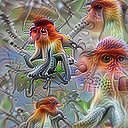

  1%|          | 4/512 [00:00<00:14, 33.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 8/512 [00:00<00:27, 18.56it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 11/512 [00:01<01:09,  7.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 13/512 [00:01<01:26,  5.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 15/512 [00:02<01:38,  5.03it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 16/512 [00:02<01:46,  4.67it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 18/512 [00:03<01:54,  4.32it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 19/512 [00:03<01:56,  4.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 20/512 [00:03<01:58,  4.14it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 21/512 [00:03<02:04,  3.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 22/512 [00:04<02:04,  3.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 23/512 [00:04<02:04,  3.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 24/512 [00:04<02:07,  3.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 25/512 [00:04<02:07,  3.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 26/512 [00:05<02:06,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 28/512 [00:05<02:03,  3.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 29/512 [00:05<02:06,  3.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 30/512 [00:06<02:07,  3.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 31/512 [00:06<02:05,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▋         | 32/512 [00:06<02:06,  3.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▋         | 33/512 [00:07<02:10,  3.67it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 34/512 [00:07<02:08,  3.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 36/512 [00:07<01:47,  4.43it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 40/512 [00:08<01:06,  7.12it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 42/512 [00:08<01:00,  7.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▊         | 44/512 [00:08<00:56,  8.35it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 46/512 [00:08<00:52,  8.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 47/512 [00:08<00:55,  8.44it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 10%|█         | 53/512 [00:09<00:24, 18.69it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 12%|█▏        | 61/512 [00:09<00:16, 27.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 13%|█▎        | 69/512 [00:09<00:13, 31.69it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 15%|█▌        | 77/512 [00:09<00:12, 34.06it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 17%|█▋        | 85/512 [00:09<00:12, 35.18it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 17%|█▋        | 89/512 [00:10<00:11, 35.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 18%|█▊        | 93/512 [00:10<00:19, 21.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 20%|█▉        | 100/512 [00:10<00:16, 24.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 21%|██        | 107/512 [00:10<00:14, 27.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 22%|██▏       | 115/512 [00:11<00:13, 29.43it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 24%|██▍       | 123/512 [00:11<00:12, 31.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 25%|██▍       | 127/512 [00:11<00:12, 31.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 26%|██▋       | 135/512 [00:11<00:11, 33.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 28%|██▊       | 143/512 [00:11<00:10, 34.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 29%|██▉       | 151/512 [00:12<00:10, 34.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 31%|███       | 159/512 [00:12<00:10, 35.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 33%|███▎      | 167/512 [00:12<00:09, 35.05it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 34%|███▍      | 175/512 [00:12<00:09, 35.74it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 36%|███▌      | 183/512 [00:13<00:09, 36.13it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 37%|███▋      | 191/512 [00:13<00:08, 36.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 39%|███▉      | 199/512 [00:13<00:08, 36.03it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 40%|████      | 207/512 [00:13<00:08, 35.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 42%|████▏     | 215/512 [00:13<00:08, 36.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▎     | 223/512 [00:14<00:07, 36.32it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▌     | 231/512 [00:14<00:07, 36.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 239/512 [00:14<00:07, 36.28it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 247/512 [00:14<00:07, 35.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|████▉     | 255/512 [00:15<00:07, 35.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████▏    | 263/512 [00:15<00:07, 35.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 267/512 [00:15<00:11, 21.13it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 270/512 [00:16<00:23, 10.14it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 273/512 [00:17<00:33,  7.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▎    | 275/512 [00:17<00:38,  6.12it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 277/512 [00:18<00:43,  5.38it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 279/512 [00:18<00:47,  4.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▍    | 280/512 [00:19<00:49,  4.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▍    | 281/512 [00:19<00:51,  4.44it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 282/512 [00:19<00:53,  4.33it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 283/512 [00:19<00:55,  4.13it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 284/512 [00:20<00:57,  3.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 285/512 [00:20<00:57,  3.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 287/512 [00:20<00:56,  4.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▋    | 288/512 [00:21<00:56,  3.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 290/512 [00:21<00:56,  3.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 291/512 [00:21<00:58,  3.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 293/512 [00:22<00:57,  3.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 295/512 [00:22<00:52,  4.15it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 298/512 [00:23<00:33,  6.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▊    | 300/512 [00:23<00:28,  7.44it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▉    | 302/512 [00:23<00:25,  8.10it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▉    | 303/512 [00:23<00:25,  8.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 305/512 [00:23<00:23,  8.70it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 61%|██████▏   | 314/512 [00:24<00:10, 19.65it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 63%|██████▎   | 322/512 [00:24<00:06, 27.67it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 64%|██████▍   | 330/512 [00:24<00:05, 31.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 66%|██████▌   | 338/512 [00:25<00:05, 34.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 68%|██████▊   | 346/512 [00:25<00:04, 35.66it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 68%|██████▊   | 350/512 [00:25<00:04, 35.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 70%|██████▉   | 358/512 [00:25<00:05, 29.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 71%|███████▏  | 366/512 [00:25<00:04, 31.28it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 73%|███████▎  | 374/512 [00:26<00:04, 30.70it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 74%|███████▍  | 378/512 [00:26<00:04, 29.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 75%|███████▌  | 385/512 [00:26<00:04, 29.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 76%|███████▋  | 391/512 [00:26<00:04, 28.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 78%|███████▊  | 398/512 [00:27<00:03, 29.24it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 79%|███████▉  | 404/512 [00:27<00:03, 29.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 80%|████████  | 410/512 [00:27<00:03, 29.17it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 81%|████████▏ | 416/512 [00:27<00:03, 28.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 82%|████████▏ | 422/512 [00:27<00:03, 28.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 84%|████████▍ | 429/512 [00:28<00:02, 29.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 85%|████████▌ | 437/512 [00:28<00:02, 29.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 87%|████████▋ | 443/512 [00:28<00:02, 29.76it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 88%|████████▊ | 449/512 [00:28<00:02, 29.60it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 89%|████████▉ | 456/512 [00:29<00:01, 29.63it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 90%|█████████ | 463/512 [00:29<00:01, 29.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 91%|█████████ | 466/512 [00:29<00:01, 28.50it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 475/512 [00:29<00:01, 28.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▎| 479/512 [00:29<00:01, 29.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▍| 485/512 [00:30<00:00, 29.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 492/512 [00:30<00:00, 29.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 499/512 [00:30<00:00, 30.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 506/512 [00:30<00:00, 29.53it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|██████████| 512/512 [00:30<00:00, 16.55it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]



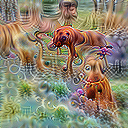

  0%|          | 0/512 [00:00<?, ?it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  0%|          | 2/512 [00:00<02:06,  4.02it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 3/512 [00:00<02:14,  3.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 4/512 [00:01<02:18,  3.67it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 5/512 [00:01<02:14,  3.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 6/512 [00:01<02:16,  3.70it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|▏         | 7/512 [00:01<02:17,  3.69it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 8/512 [00:02<02:14,  3.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 10/512 [00:02<02:05,  3.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 11/512 [00:02<02:06,  3.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 12/512 [00:03<02:06,  3.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 13/512 [00:03<02:09,  3.84it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 14/512 [00:03<02:11,  3.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 15/512 [00:03<02:10,  3.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 17/512 [00:04<02:04,  3.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 18/512 [00:04<02:08,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 19/512 [00:04<02:07,  3.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 20/512 [00:05<02:06,  3.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 21/512 [00:05<02:06,  3.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 22/512 [00:05<02:05,  3.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 23/512 [00:05<02:09,  3.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 24/512 [00:06<02:12,  3.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 27/512 [00:06<01:23,  5.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 31/512 [00:07<01:02,  7.66it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▋         | 33/512 [00:07<00:58,  8.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 34/512 [00:07<00:56,  8.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 36/512 [00:07<00:56,  8.36it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 38/512 [00:07<00:55,  8.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 46/512 [00:08<00:21, 21.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 11%|█         | 54/512 [00:08<00:15, 29.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 12%|█▏        | 62/512 [00:08<00:13, 32.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 14%|█▎        | 70/512 [00:08<00:12, 34.43it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 15%|█▌        | 78/512 [00:09<00:12, 35.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 17%|█▋        | 86/512 [00:09<00:11, 35.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 18%|█▊        | 94/512 [00:09<00:11, 35.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 21%|██        | 106/512 [00:09<00:10, 36.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 21%|██▏       | 110/512 [00:09<00:11, 36.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 23%|██▎       | 118/512 [00:10<00:13, 30.02it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 25%|██▍       | 126/512 [00:10<00:11, 33.18it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 26%|██▌       | 134/512 [00:10<00:10, 34.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 28%|██▊       | 142/512 [00:10<00:10, 35.38it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 29%|██▉       | 150/512 [00:11<00:10, 35.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 31%|███       | 158/512 [00:11<00:09, 36.08it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 32%|███▏      | 166/512 [00:11<00:09, 36.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 34%|███▍      | 174/512 [00:11<00:09, 36.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 36%|███▌      | 182/512 [00:11<00:09, 36.39it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 37%|███▋      | 190/512 [00:12<00:08, 36.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 39%|███▊      | 198/512 [00:12<00:08, 36.65it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 40%|████      | 206/512 [00:12<00:08, 36.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 42%|████▏     | 214/512 [00:12<00:08, 36.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 43%|████▎     | 222/512 [00:13<00:07, 36.43it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▍     | 230/512 [00:13<00:07, 36.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▋     | 238/512 [00:13<00:07, 36.21it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 246/512 [00:13<00:07, 36.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|████▉     | 254/512 [00:13<00:07, 36.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 262/512 [00:14<00:06, 35.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 270/512 [00:14<00:06, 36.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 278/512 [00:14<00:06, 36.14it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 286/512 [00:14<00:06, 36.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 290/512 [00:14<00:06, 34.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 294/512 [00:15<00:14, 14.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 297/512 [00:16<00:24,  8.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 299/512 [00:16<00:30,  7.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▉    | 301/512 [00:17<00:35,  5.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▉    | 303/512 [00:17<00:38,  5.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 305/512 [00:18<00:41,  4.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 306/512 [00:18<00:44,  4.60it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|██████    | 308/512 [00:19<00:47,  4.32it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|██████    | 309/512 [00:19<00:49,  4.06it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 61%|██████    | 311/512 [00:19<00:49,  4.06it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 61%|██████    | 312/512 [00:20<00:50,  3.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 61%|██████▏   | 314/512 [00:20<00:50,  3.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 315/512 [00:21<00:51,  3.84it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 316/512 [00:21<00:50,  3.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 317/512 [00:21<00:51,  3.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 318/512 [00:21<00:52,  3.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▎   | 320/512 [00:22<00:49,  3.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 63%|██████▎   | 321/512 [00:22<00:43,  4.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 63%|██████▎   | 324/512 [00:22<00:28,  6.61it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 64%|██████▎   | 326/512 [00:22<00:23,  7.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 64%|██████▍   | 329/512 [00:23<00:21,  8.60it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 65%|██████▍   | 331/512 [00:23<00:20,  8.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 65%|██████▌   | 333/512 [00:23<00:20,  8.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 66%|██████▌   | 337/512 [00:23<00:11, 15.84it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 67%|██████▋   | 345/512 [00:24<00:06, 25.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 69%|██████▉   | 353/512 [00:24<00:05, 30.33it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 71%|███████   | 361/512 [00:24<00:04, 33.33it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 72%|███████▏  | 369/512 [00:24<00:04, 34.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 74%|███████▎  | 377/512 [00:25<00:03, 35.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 75%|███████▌  | 385/512 [00:25<00:03, 36.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 77%|███████▋  | 393/512 [00:25<00:04, 26.48it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 78%|███████▊  | 401/512 [00:25<00:03, 29.40it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 79%|███████▉  | 405/512 [00:26<00:03, 29.52it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 81%|████████  | 413/512 [00:26<00:03, 29.58it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 82%|████████▏ | 421/512 [00:26<00:02, 31.28it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 83%|████████▎ | 425/512 [00:26<00:02, 32.15it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 85%|████████▍ | 433/512 [00:26<00:02, 33.18it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 86%|████████▌ | 441/512 [00:27<00:02, 33.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 88%|████████▊ | 449/512 [00:27<00:01, 34.64it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 89%|████████▉ | 457/512 [00:27<00:01, 34.29it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 91%|█████████ | 465/512 [00:27<00:01, 34.58it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 92%|█████████▏| 473/512 [00:28<00:01, 34.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 481/512 [00:28<00:00, 35.63it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 489/512 [00:28<00:00, 36.03it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 497/512 [00:28<00:00, 36.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▊| 505/512 [00:28<00:00, 36.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|██████████| 512/512 [00:29<00:00, 17.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]



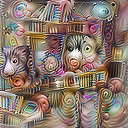

  1%|          | 4/512 [00:00<00:14, 34.05it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 8/512 [00:00<00:27, 18.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 11/512 [00:01<01:08,  7.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 13/512 [00:01<01:27,  5.70it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 14/512 [00:02<01:33,  5.35it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 15/512 [00:02<01:40,  4.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 17/512 [00:02<01:48,  4.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 19/512 [00:03<01:55,  4.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 20/512 [00:03<02:00,  4.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 22/512 [00:04<02:01,  4.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 24/512 [00:04<02:01,  4.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 25/512 [00:04<02:02,  3.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 26/512 [00:05<02:03,  3.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 27/512 [00:05<02:04,  3.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 29/512 [00:05<02:01,  3.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 30/512 [00:06<02:04,  3.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▋         | 32/512 [00:06<02:03,  3.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 34/512 [00:07<02:00,  3.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 35/512 [00:07<02:04,  3.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 38/512 [00:07<01:21,  5.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▊         | 44/512 [00:08<00:38, 12.21it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 46/512 [00:08<00:45, 10.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 48/512 [00:08<00:47,  9.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 10%|▉         | 50/512 [00:08<00:47,  9.63it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 10%|█         | 52/512 [00:09<00:48,  9.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 11%|█▏        | 58/512 [00:09<00:30, 14.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 13%|█▎        | 66/512 [00:09<00:19, 23.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 14%|█▍        | 74/512 [00:09<00:15, 28.66it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 16%|█▌        | 82/512 [00:09<00:13, 32.14it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 18%|█▊        | 90/512 [00:10<00:12, 34.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 19%|█▉        | 98/512 [00:10<00:11, 35.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 20%|█▉        | 102/512 [00:10<00:11, 35.63it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 21%|██▏       | 110/512 [00:10<00:13, 29.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 22%|██▏       | 114/512 [00:10<00:13, 30.40it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 24%|██▍       | 122/512 [00:11<00:12, 31.76it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 25%|██▌       | 130/512 [00:11<00:12, 31.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 27%|██▋       | 138/512 [00:11<00:11, 31.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 28%|██▊       | 142/512 [00:11<00:11, 32.10it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 29%|██▉       | 150/512 [00:12<00:12, 30.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 30%|███       | 154/512 [00:12<00:11, 30.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 32%|███▏      | 162/512 [00:12<00:11, 31.36it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 33%|███▎      | 170/512 [00:12<00:10, 31.29it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 35%|███▍      | 178/512 [00:13<00:10, 31.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 36%|███▌      | 182/512 [00:13<00:10, 31.51it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 37%|███▋      | 190/512 [00:13<00:10, 30.39it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 39%|███▊      | 198/512 [00:13<00:09, 31.46it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 40%|████      | 206/512 [00:13<00:09, 31.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 41%|████      | 210/512 [00:14<00:09, 31.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 43%|████▎     | 218/512 [00:14<00:09, 32.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▍     | 226/512 [00:14<00:08, 32.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 234/512 [00:14<00:08, 32.55it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▋     | 238/512 [00:14<00:08, 32.32it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 246/512 [00:15<00:08, 32.13it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|████▉     | 254/512 [00:15<00:08, 32.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 262/512 [00:15<00:08, 30.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 266/512 [00:16<00:11, 20.65it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 269/512 [00:16<00:24,  9.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 271/512 [00:17<00:31,  7.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 273/512 [00:17<00:38,  6.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 276/512 [00:18<00:45,  5.13it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 277/512 [00:18<00:48,  4.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 278/512 [00:19<00:51,  4.55it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 279/512 [00:19<00:53,  4.36it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▍    | 280/512 [00:19<00:53,  4.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▍    | 281/512 [00:19<00:54,  4.21it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 282/512 [00:20<00:57,  3.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 283/512 [00:20<00:57,  3.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 284/512 [00:20<00:57,  3.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 286/512 [00:21<00:56,  4.00it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 287/512 [00:21<00:55,  4.06it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▋    | 288/512 [00:21<00:54,  4.10it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▋    | 289/512 [00:22<00:56,  3.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 290/512 [00:22<00:55,  3.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 291/512 [00:22<00:56,  3.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 292/512 [00:22<00:57,  3.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 293/512 [00:23<00:56,  3.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 296/512 [00:23<00:36,  5.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 298/512 [00:23<00:31,  6.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▉    | 301/512 [00:24<00:26,  7.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▉    | 303/512 [00:24<00:24,  8.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 305/512 [00:24<00:24,  8.45it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 307/512 [00:24<00:20, 10.15it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 315/512 [00:24<00:08, 22.29it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 63%|██████▎   | 323/512 [00:25<00:06, 29.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 65%|██████▍   | 331/512 [00:25<00:05, 32.40it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 66%|██████▌   | 339/512 [00:25<00:04, 34.64it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 68%|██████▊   | 347/512 [00:25<00:04, 35.65it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 69%|██████▉   | 355/512 [00:25<00:04, 35.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 71%|███████   | 363/512 [00:26<00:04, 36.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 72%|███████▏  | 371/512 [00:26<00:03, 36.56it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 74%|███████▍  | 379/512 [00:26<00:03, 36.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 76%|███████▌  | 387/512 [00:26<00:03, 32.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 76%|███████▋  | 391/512 [00:26<00:03, 33.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 78%|███████▊  | 399/512 [00:27<00:03, 32.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 79%|███████▉  | 407/512 [00:27<00:03, 30.48it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 80%|████████  | 411/512 [00:27<00:03, 30.74it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 82%|████████▏ | 419/512 [00:27<00:02, 31.27it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 83%|████████▎ | 427/512 [00:28<00:02, 31.69it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 85%|████████▍ | 435/512 [00:28<00:02, 32.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 86%|████████▌ | 439/512 [00:28<00:02, 32.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 87%|████████▋ | 447/512 [00:28<00:02, 30.65it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 88%|████████▊ | 451/512 [00:28<00:02, 30.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 90%|████████▉ | 459/512 [00:29<00:01, 30.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 91%|█████████ | 467/512 [00:29<00:01, 31.54it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 475/512 [00:29<00:01, 30.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▎| 479/512 [00:29<00:01, 31.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▌| 487/512 [00:30<00:00, 30.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 495/512 [00:30<00:00, 32.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 499/512 [00:30<00:00, 32.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 507/512 [00:30<00:00, 32.53it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|██████████| 512/512 [00:30<00:00, 16.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]



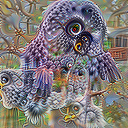

  1%|          | 6/512 [00:00<00:17, 28.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 9/512 [00:00<01:10,  7.17it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 11/512 [00:01<01:26,  5.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 13/512 [00:02<01:38,  5.05it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 14/512 [00:02<01:45,  4.70it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 15/512 [00:02<01:49,  4.52it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 16/512 [00:02<01:52,  4.40it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 18/512 [00:03<01:58,  4.15it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 19/512 [00:03<02:04,  3.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 21/512 [00:04<02:05,  3.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 22/512 [00:04<02:07,  3.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 23/512 [00:04<02:06,  3.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 24/512 [00:04<02:06,  3.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 26/512 [00:05<02:03,  3.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 28/512 [00:05<02:00,  4.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 29/512 [00:06<02:03,  3.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 31/512 [00:06<02:01,  3.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▋         | 32/512 [00:06<01:58,  4.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▋         | 33/512 [00:07<02:01,  3.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 34/512 [00:07<02:02,  3.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 37/512 [00:07<01:24,  5.60it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 40/512 [00:08<01:05,  7.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 42/512 [00:08<00:59,  7.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▊         | 44/512 [00:08<00:57,  8.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 46/512 [00:08<00:52,  8.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 48/512 [00:09<00:52,  8.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 10%|█         | 52/512 [00:09<00:27, 16.69it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 12%|█▏        | 60/512 [00:09<00:16, 26.62it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 13%|█▎        | 68/512 [00:09<00:14, 31.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 15%|█▍        | 76/512 [00:09<00:12, 33.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 16%|█▋        | 84/512 [00:10<00:12, 35.13it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 18%|█▊        | 92/512 [00:10<00:12, 34.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 19%|█▉        | 96/512 [00:10<00:16, 25.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 20%|██        | 104/512 [00:10<00:14, 28.33it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 22%|██▏       | 112/512 [00:11<00:13, 29.60it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 23%|██▎       | 120/512 [00:11<00:12, 30.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 24%|██▍       | 124/512 [00:11<00:13, 29.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 26%|██▌       | 132/512 [00:11<00:13, 28.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 27%|██▋       | 136/512 [00:11<00:12, 29.51it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 28%|██▊       | 144/512 [00:12<00:12, 29.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 30%|██▉       | 152/512 [00:12<00:11, 30.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 31%|███▏      | 160/512 [00:12<00:11, 31.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 32%|███▏      | 164/512 [00:12<00:11, 31.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 34%|███▎      | 172/512 [00:13<00:11, 30.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 35%|███▌      | 180/512 [00:13<00:10, 31.35it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 37%|███▋      | 188/512 [00:13<00:10, 31.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 38%|███▊      | 192/512 [00:13<00:09, 32.05it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 39%|███▉      | 200/512 [00:13<00:10, 30.66it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 40%|███▉      | 204/512 [00:14<00:10, 30.62it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 41%|████▏     | 212/512 [00:14<00:09, 30.53it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 43%|████▎     | 220/512 [00:14<00:09, 31.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▍     | 228/512 [00:14<00:08, 31.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▌     | 232/512 [00:14<00:08, 31.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 236/512 [00:15<00:08, 31.05it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 240/512 [00:15<00:14, 18.66it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 243/512 [00:16<00:27,  9.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 245/512 [00:16<00:35,  7.56it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 247/512 [00:17<00:41,  6.33it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▊     | 249/512 [00:17<00:48,  5.48it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 250/512 [00:18<00:50,  5.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 251/512 [00:18<00:53,  4.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 252/512 [00:18<00:56,  4.58it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 253/512 [00:18<00:58,  4.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|████▉     | 254/512 [00:19<01:00,  4.27it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|████▉     | 255/512 [00:19<01:01,  4.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|█████     | 256/512 [00:19<01:04,  4.00it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|█████     | 257/512 [00:19<01:03,  4.02it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|█████     | 258/512 [00:20<01:03,  3.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 259/512 [00:20<01:04,  3.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 260/512 [00:20<01:04,  3.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 261/512 [00:20<01:04,  3.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████▏    | 263/512 [00:21<01:03,  3.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 264/512 [00:21<01:05,  3.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 266/512 [00:22<01:03,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 268/512 [00:22<00:59,  4.08it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 272/512 [00:23<00:33,  7.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▎    | 274/512 [00:23<00:29,  7.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 276/512 [00:23<00:27,  8.45it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 278/512 [00:23<00:26,  8.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 279/512 [00:23<00:26,  8.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 286/512 [00:24<00:12, 18.63it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 294/512 [00:24<00:07, 27.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 59%|█████▉    | 302/512 [00:24<00:06, 31.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 61%|██████    | 310/512 [00:24<00:05, 34.34it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 318/512 [00:25<00:05, 34.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 63%|██████▎   | 322/512 [00:25<00:05, 34.58it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 64%|██████▍   | 330/512 [00:25<00:07, 25.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 66%|██████▌   | 338/512 [00:25<00:05, 29.51it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 67%|██████▋   | 342/512 [00:25<00:05, 30.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 68%|██████▊   | 350/512 [00:26<00:04, 33.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 70%|██████▉   | 358/512 [00:26<00:04, 31.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 71%|███████▏  | 366/512 [00:26<00:04, 32.28it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 72%|███████▏  | 370/512 [00:26<00:04, 31.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 74%|███████▍  | 378/512 [00:27<00:04, 32.51it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 75%|███████▌  | 386/512 [00:27<00:03, 32.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 77%|███████▋  | 394/512 [00:27<00:03, 32.49it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 79%|███████▊  | 402/512 [00:27<00:03, 33.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 80%|████████  | 410/512 [00:28<00:02, 34.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 82%|████████▏ | 418/512 [00:28<00:02, 35.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 83%|████████▎ | 426/512 [00:28<00:02, 35.33it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 85%|████████▍ | 434/512 [00:28<00:02, 35.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 86%|████████▋ | 442/512 [00:28<00:01, 36.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 88%|████████▊ | 450/512 [00:29<00:01, 36.35it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 89%|████████▉ | 458/512 [00:29<00:01, 35.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 91%|█████████ | 466/512 [00:29<00:01, 35.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 474/512 [00:29<00:01, 35.84it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 482/512 [00:30<00:00, 34.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [

 95%|█████████▍| 486/512 [00:30<00:01, 20.00it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 489/512 [00:31<00:02,  9.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 492/512 [00:31<00:02,  7.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▋| 494/512 [00:32<00:02,  6.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 496/512 [00:33<00:02,  5.38it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 497/512 [00:33<00:02,  5.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 498/512 [00:33<00:02,  4.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 499/512 [00:33<00:02,  4.58it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 500/512 [00:34<00:02,  4.39it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 501/512 [00:34<00:02,  4.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 502/512 [00:34<00:02,  4.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 504/512 [00:35<00:01,  4.08it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▊| 505/512 [00:35<00:01,  3.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 507/512 [00:35<00:01,  3.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 509/512 [00:36<00:00,  4.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|█████████▉| 510/512 [00:36<00:00,  3.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|█████████▉| 511/512 [00:36<00:00,  3.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|██████████| 512/512 [00:37<00:00, 13.77it/s]



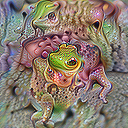

  0%|          | 0/512 [00:00<?, ?it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  0%|          | 2/512 [00:00<01:46,  4.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 4/512 [00:00<01:17,  6.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|▏         | 7/512 [00:01<01:03,  7.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 9/512 [00:01<00:59,  8.45it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 11/512 [00:01<00:57,  8.74it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 13/512 [00:01<00:57,  8.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 17/512 [00:01<00:30, 16.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 25/512 [00:02<00:18, 26.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▋         | 33/512 [00:02<00:15, 30.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 41/512 [00:02<00:14, 33.61it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 10%|▉         | 49/512 [00:02<00:13, 34.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 11%|█         | 57/512 [00:02<00:13, 33.65it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 12%|█▏        | 61/512 [00:03<00:15, 29.61it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 13%|█▎        | 69/512 [00:03<00:14, 29.56it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 15%|█▌        | 77/512 [00:03<00:14, 30.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 17%|█▋        | 85/512 [00:03<00:13, 31.15it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 17%|█▋        | 89/512 [00:04<00:13, 31.21it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 19%|█▉        | 97/512 [00:04<00:13, 31.40it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 21%|██        | 105/512 [00:04<00:13, 30.58it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 21%|██▏       | 109/512 [00:04<00:13, 30.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 23%|██▎       | 117/512 [00:04<00:12, 31.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 24%|██▍       | 125/512 [00:05<00:12, 31.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 26%|██▌       | 133/512 [00:05<00:12, 31.34it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 27%|██▋       | 137/512 [00:05<00:12, 30.33it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 28%|██▊       | 145/512 [00:05<00:11, 31.17it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 30%|██▉       | 153/512 [00:06<00:11, 31.40it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 31%|███▏      | 161/512 [00:06<00:11, 31.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 32%|███▏      | 165/512 [00:06<00:10, 32.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 34%|███▍      | 173/512 [00:06<00:10, 31.62it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 35%|███▌      | 181/512 [00:06<00:10, 31.18it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 37%|███▋      | 189/512 [00:07<00:10, 31.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 38%|███▊      | 193/512 [00:07<00:10, 31.56it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 39%|███▉      | 201/512 [00:07<00:09, 31.13it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 41%|████      | 209/512 [00:07<00:09, 30.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 42%|████▏     | 213/512 [00:07<00:09, 30.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 42%|████▏     | 217/512 [00:08<00:09, 30.70it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 43%|████▎     | 221/512 [00:08<00:13, 21.66it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▍     | 224/512 [00:09<00:28, 10.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▍     | 226/512 [00:09<00:36,  7.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▍     | 228/512 [00:10<00:44,  6.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▍     | 230/512 [00:10<00:51,  5.49it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▌     | 231/512 [00:11<00:53,  5.21it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▌     | 232/512 [00:11<00:57,  4.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 234/512 [00:11<01:00,  4.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 235/512 [00:12<01:04,  4.32it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 236/512 [00:12<01:06,  4.14it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▋     | 237/512 [00:12<01:07,  4.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▋     | 238/512 [00:12<01:09,  3.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 239/512 [00:13<01:08,  3.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 240/512 [00:13<01:09,  3.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 241/512 [00:13<01:09,  3.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 242/512 [00:13<01:08,  3.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 243/512 [00:14<01:11,  3.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 244/512 [00:14<01:08,  3.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 245/512 [00:14<01:07,  3.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 246/512 [00:14<01:08,  3.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 247/512 [00:15<01:08,  3.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 248/512 [00:15<01:11,  3.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 251/512 [00:15<00:48,  5.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|████▉     | 254/512 [00:16<00:36,  7.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|█████     | 256/512 [00:16<00:32,  7.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|█████     | 258/512 [00:16<00:30,  8.34it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 260/512 [00:16<00:29,  8.53it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 261/512 [00:17<00:29,  8.65it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 53%|█████▎    | 269/512 [00:17<00:11, 21.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▍    | 277/512 [00:17<00:08, 28.76it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 56%|█████▌    | 285/512 [00:17<00:06, 32.50it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 293/512 [00:17<00:06, 34.60it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 305/512 [00:18<00:05, 35.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|██████    | 309/512 [00:18<00:07, 28.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 317/512 [00:18<00:06, 31.08it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 63%|██████▎   | 325/512 [00:18<00:05, 31.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 64%|██████▍   | 329/512 [00:19<00:05, 31.03it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 66%|██████▌   | 337/512 [00:19<00:05, 32.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 67%|██████▋   | 345/512 [00:19<00:04, 34.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 69%|██████▉   | 353/512 [00:19<00:04, 34.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 71%|███████   | 361/512 [00:19<00:04, 35.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 72%|███████▏  | 369/512 [00:20<00:03, 35.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 74%|███████▎  | 377/512 [00:20<00:03, 36.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 75%|███████▌  | 385/512 [00:20<00:03, 36.70it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 77%|███████▋  | 393/512 [00:20<00:03, 36.48it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 78%|███████▊  | 401/512 [00:21<00:03, 36.03it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 80%|███████▉  | 409/512 [00:21<00:02, 35.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 81%|████████▏ | 417/512 [00:21<00:02, 36.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 83%|████████▎ | 425/512 [00:21<00:02, 36.27it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 85%|████████▍ | 433/512 [00:21<00:02, 36.36it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 86%|████████▌ | 441/512 [00:22<00:01, 35.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 88%|████████▊ | 449/512 [00:22<00:01, 36.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 89%|████████▉ | 457/512 [00:22<00:01, 36.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 91%|█████████ | 465/512 [00:22<00:01, 36.50it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 92%|█████████▏| 473/512 [00:23<00:01, 36.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 481/512 [00:23<00:00, 34.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 489/512 [00:23<00:00, 33.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 497/512 [00:23<00:00, 33.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 501/512 [00:23<00:00, 34.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▊| 505/512 [00:24<00:00, 25.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 508/512 [00:24<00:00, 10.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|██████████| 512/512 [00:25<00:00, 19.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]



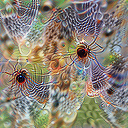

  0%|          | 0/512 [00:00<?, ?it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  0%|          | 1/512 [00:00<02:23,  3.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 3/512 [00:00<02:09,  3.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 4/512 [00:01<02:14,  3.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 6/512 [00:01<02:08,  3.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|▏         | 7/512 [00:01<02:06,  4.00it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 8/512 [00:02<02:07,  3.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 9/512 [00:02<02:10,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 10/512 [00:02<02:09,  3.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 11/512 [00:02<02:10,  3.84it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 12/512 [00:03<02:08,  3.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 13/512 [00:03<02:08,  3.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 14/512 [00:03<02:11,  3.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 15/512 [00:03<02:10,  3.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 16/512 [00:04<02:08,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 17/512 [00:04<02:07,  3.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 18/512 [00:04<02:07,  3.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 19/512 [00:04<02:10,  3.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 20/512 [00:05<02:07,  3.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 22/512 [00:05<01:48,  4.52it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 24/512 [00:05<01:22,  5.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 26/512 [00:06<01:11,  6.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 29/512 [00:06<00:57,  8.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 31/512 [00:06<00:55,  8.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▋         | 32/512 [00:06<00:54,  8.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 35/512 [00:06<00:42, 11.14it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 43/512 [00:07<00:20, 23.32it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 10%|▉         | 51/512 [00:07<00:16, 28.76it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 12%|█▏        | 59/512 [00:07<00:13, 32.38it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 13%|█▎        | 67/512 [00:07<00:12, 34.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 15%|█▍        | 75/512 [00:08<00:12, 35.21it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 15%|█▌        | 79/512 [00:08<00:14, 29.24it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 17%|█▋        | 87/512 [00:08<00:14, 30.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 19%|█▊        | 95/512 [00:08<00:13, 31.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 19%|█▉        | 99/512 [00:08<00:12, 32.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 21%|██        | 107/512 [00:09<00:12, 31.55it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 22%|██▏       | 115/512 [00:09<00:12, 31.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 24%|██▍       | 123/512 [00:09<00:12, 31.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 25%|██▍       | 127/512 [00:09<00:12, 30.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 26%|██▋       | 135/512 [00:09<00:11, 31.46it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 28%|██▊       | 143/512 [00:10<00:11, 32.36it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 29%|██▉       | 151/512 [00:10<00:11, 31.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 30%|███       | 155/512 [00:10<00:11, 31.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 32%|███▏      | 163/512 [00:10<00:11, 31.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 33%|███▎      | 171/512 [00:11<00:10, 31.61it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 35%|███▍      | 179/512 [00:11<00:10, 31.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 36%|███▌      | 183/512 [00:11<00:10, 31.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 37%|███▋      | 191/512 [00:11<00:10, 31.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 39%|███▉      | 199/512 [00:12<00:10, 31.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 40%|████      | 207/512 [00:12<00:09, 31.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 41%|████      | 211/512 [00:12<00:09, 31.28it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 43%|████▎     | 219/512 [00:12<00:09, 30.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▍     | 227/512 [00:12<00:09, 30.54it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▌     | 231/512 [00:13<00:28,  9.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 234/512 [00:14<00:39,  7.03it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 236/512 [00:15<00:46,  5.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▋     | 238/512 [00:15<00:52,  5.21it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 240/512 [00:16<00:57,  4.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 241/512 [00:16<01:00,  4.46it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 243/512 [00:17<01:03,  4.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 244/512 [00:17<01:06,  4.05it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 245/512 [00:17<01:06,  4.03it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 246/512 [00:18<01:06,  4.02it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 247/512 [00:18<01:07,  3.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▊     | 249/512 [00:18<01:06,  3.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 250/512 [00:19<01:08,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 251/512 [00:19<01:07,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 252/512 [00:19<01:08,  3.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|████▉     | 254/512 [00:20<01:05,  3.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|█████     | 257/512 [00:20<00:44,  5.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 260/512 [00:20<00:34,  7.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 262/512 [00:21<00:31,  7.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 264/512 [00:21<00:29,  8.40it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 266/512 [00:21<00:28,  8.74it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 267/512 [00:21<00:28,  8.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▎    | 274/512 [00:21<00:11, 20.13it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 282/512 [00:22<00:08, 28.24it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 290/512 [00:22<00:06, 32.10it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 298/512 [00:22<00:06, 33.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 306/512 [00:22<00:05, 34.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 61%|██████    | 310/512 [00:22<00:05, 35.50it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 317/512 [00:23<00:09, 21.67it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 63%|██████▎   | 323/512 [00:23<00:07, 24.33it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 64%|██████▍   | 329/512 [00:23<00:07, 26.12it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 65%|██████▌   | 335/512 [00:24<00:06, 26.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 66%|██████▌   | 339/512 [00:24<00:05, 28.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 68%|██████▊   | 347/512 [00:24<00:05, 30.51it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 69%|██████▉   | 355/512 [00:24<00:04, 31.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 71%|███████   | 363/512 [00:24<00:04, 33.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 72%|███████▏  | 371/512 [00:25<00:04, 34.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 74%|███████▍  | 379/512 [00:25<00:03, 35.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 76%|███████▌  | 387/512 [00:25<00:03, 35.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 77%|███████▋  | 395/512 [00:25<00:03, 35.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 79%|███████▊  | 403/512 [00:26<00:03, 35.52it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 80%|████████  | 411/512 [00:26<00:02, 35.56it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 82%|████████▏ | 419/512 [00:26<00:02, 35.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 83%|████████▎ | 427/512 [00:26<00:02, 35.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 85%|████████▍ | 435/512 [00:26<00:02, 35.68it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 87%|████████▋ | 443/512 [00:27<00:01, 35.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 88%|████████▊ | 451/512 [00:27<00:01, 35.48it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 90%|████████▉ | 459/512 [00:27<00:01, 35.32it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 90%|█████████ | 463/512 [00:27<00:01, 34.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 91%|█████████ | 467/512 [00:28<00:04, 11.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 92%|█████████▏| 470/512 [00:29<00:05,  7.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 92%|█████████▏| 472/512 [00:29<00:06,  6.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 474/512 [00:30<00:06,  5.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 476/512 [00:30<00:06,  5.21it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 478/512 [00:31<00:07,  4.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▎| 479/512 [00:31<00:07,  4.53it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 480/512 [00:31<00:07,  4.38it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 481/512 [00:32<00:07,  4.24it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 483/512 [00:32<00:06,  4.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▍| 485/512 [00:33<00:06,  4.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▍| 486/512 [00:33<00:06,  3.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▌| 488/512 [00:34<00:06,  3.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 490/512 [00:34<00:05,  4.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 491/512 [00:34<00:05,  3.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▋| 493/512 [00:35<00:04,  4.08it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 495/512 [00:35<00:02,  5.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 498/512 [00:35<00:01,  7.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 500/512 [00:35<00:01,  7.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 502/512 [00:36<00:01,  8.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 504/512 [00:36<00:00,  8.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 509/512 [00:36<00:00, 16.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|██████████| 512/512 [00:36<00:00, 13.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]



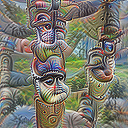

  0%|          | 0/512 [00:00<?, ?it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 4/512 [00:00<00:14, 34.54it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 8/512 [00:00<00:14, 34.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 12/512 [00:00<00:14, 34.84it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 16/512 [00:00<00:13, 35.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 20/512 [00:00<00:13, 35.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▍         | 24/512 [00:00<00:13, 36.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 28/512 [00:00<00:13, 36.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▋         | 32/512 [00:00<00:13, 36.39it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 36/512 [00:01<00:13, 36.54it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 40/512 [00:01<00:12, 36.51it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▊         | 44/512 [00:01<00:12, 36.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 48/512 [00:01<00:12, 36.32it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 10%|█         | 52/512 [00:01<00:12, 36.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 11%|█         | 56/512 [00:01<00:14, 32.17it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 12%|█▏        | 60/512 [00:01<00:13, 33.24it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 12%|█▎        | 64/512 [00:01<00:13, 34.14it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 13%|█▎        | 68/512 [00:01<00:12, 34.51it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 14%|█▍        | 72/512 [00:02<00:12, 34.64it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 15%|█▍        | 76/512 [00:02<00:12, 35.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 16%|█▌        | 80/512 [00:02<00:12, 35.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 16%|█▋        | 84/512 [00:02<00:12, 35.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 17%|█▋        | 88/512 [00:02<00:11, 35.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 18%|█▊        | 92/512 [00:02<00:11, 36.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 19%|█▉        | 96/512 [00:02<00:11, 36.08it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 20%|█▉        | 100/512 [00:02<00:11, 36.29it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 20%|██        | 104/512 [00:02<00:11, 36.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 21%|██        | 108/512 [00:03<00:11, 36.48it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 22%|██▏       | 112/512 [00:03<00:10, 36.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 23%|██▎       | 116/512 [00:03<00:10, 36.49it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 23%|██▎       | 120/512 [00:03<00:10, 36.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 24%|██▍       | 124/512 [00:03<00:10, 36.28it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 25%|██▌       | 128/512 [00:03<00:10, 35.64it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 26%|██▌       | 132/512 [00:03<00:10, 35.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 27%|██▋       | 136/512 [00:03<00:10, 35.58it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 27%|██▋       | 140/512 [00:03<00:10, 35.66it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 28%|██▊       | 144/512 [00:04<00:10, 35.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 29%|██▉       | 148/512 [00:04<00:10, 35.92it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 30%|██▉       | 152/512 [00:04<00:10, 35.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 30%|███       | 156/512 [00:04<00:09, 35.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 31%|███▏      | 160/512 [00:04<00:09, 36.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 32%|███▏      | 164/512 [00:04<00:09, 36.12it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 33%|███▎      | 168/512 [00:04<00:09, 35.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 34%|███▎      | 172/512 [00:04<00:09, 34.62it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 34%|███▍      | 176/512 [00:04<00:09, 35.19it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 36%|███▌      | 184/512 [00:05<00:09, 35.38it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 38%|███▊      | 192/512 [00:05<00:08, 35.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 39%|███▉      | 200/512 [00:05<00:08, 36.14it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 41%|████      | 208/512 [00:05<00:08, 35.42it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 41%|████▏     | 212/512 [00:05<00:08, 35.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 42%|████▏     | 216/512 [00:06<00:08, 33.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 43%|████▎     | 220/512 [00:06<00:21, 13.63it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▎     | 223/512 [00:07<00:34,  8.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▍     | 225/512 [00:08<00:41,  6.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▍     | 227/512 [00:08<00:49,  5.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▍     | 229/512 [00:09<00:54,  5.15it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▍     | 230/512 [00:09<00:57,  4.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▌     | 231/512 [00:09<01:00,  4.67it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▌     | 232/512 [00:09<01:02,  4.45it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 233/512 [00:10<01:05,  4.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 234/512 [00:10<01:07,  4.14it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 235/512 [00:10<01:08,  4.06it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▋     | 237/512 [00:11<01:08,  4.00it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▋     | 238/512 [00:11<01:08,  3.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 240/512 [00:12<01:08,  3.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 242/512 [00:12<01:08,  3.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 243/512 [00:12<01:11,  3.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 245/512 [00:13<01:08,  3.91it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▊     | 249/512 [00:13<00:39,  6.69it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 252/512 [00:14<00:33,  7.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|████▉     | 254/512 [00:14<00:31,  8.32it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|█████     | 256/512 [00:14<00:29,  8.61it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 50%|█████     | 258/512 [00:14<00:28,  8.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 259/512 [00:14<00:29,  8.65it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 267/512 [00:15<00:11, 21.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▎    | 275/512 [00:15<00:08, 28.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 283/512 [00:15<00:07, 32.49it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 291/512 [00:15<00:06, 34.52it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 299/512 [00:16<00:06, 35.37it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 307/512 [00:16<00:06, 31.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 315/512 [00:16<00:06, 32.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 319/512 [00:16<00:05, 32.21it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 64%|██████▍   | 327/512 [00:16<00:05, 32.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 65%|██████▌   | 335/512 [00:17<00:05, 33.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 67%|██████▋   | 343/512 [00:17<00:04, 34.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 69%|██████▊   | 351/512 [00:17<00:04, 35.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 70%|███████   | 359/512 [00:17<00:04, 35.53it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 72%|███████▏  | 367/512 [00:18<00:04, 35.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 73%|███████▎  | 375/512 [00:18<00:03, 36.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 75%|███████▍  | 383/512 [00:18<00:03, 36.10it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 76%|███████▋  | 391/512 [00:18<00:03, 36.36it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 78%|███████▊  | 399/512 [00:18<00:03, 36.18it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 79%|███████▉  | 407/512 [00:19<00:02, 36.17it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 81%|████████  | 415/512 [00:19<00:02, 36.29it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 83%|████████▎ | 423/512 [00:19<00:02, 36.48it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 84%|████████▍ | 431/512 [00:19<00:02, 36.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 86%|████████▌ | 439/512 [00:20<00:02, 36.46it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 87%|████████▋ | 447/512 [00:20<00:01, 35.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 89%|████████▉ | 455/512 [00:20<00:01, 35.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 90%|█████████ | 463/512 [00:20<00:01, 35.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 92%|█████████▏| 471/512 [00:20<00:01, 34.61it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 475/512 [00:21<00:02, 16.61it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 478/512 [00:22<00:03,  9.21it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 480/512 [00:22<00:04,  7.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 482/512 [00:23<00:04,  6.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▍| 484/512 [00:23<00:05,  5.38it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▍| 485/512 [00:24<00:05,  5.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▌| 487/512 [00:24<00:05,  4.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▌| 488/512 [00:24<00:05,  4.45it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 489/512 [00:25<00:05,  4.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 490/512 [00:25<00:05,  4.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 491/512 [00:25<00:05,  4.02it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 492/512 [00:25<00:05,  3.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▋| 493/512 [00:26<00:04,  3.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 495/512 [00:26<00:04,  4.02it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 496/512 [00:26<00:04,  3.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 497/512 [00:27<00:03,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 498/512 [00:27<00:03,  3.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 499/512 [00:27<00:03,  3.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 500/512 [00:27<00:03,  3.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 501/512 [00:28<00:02,  3.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 504/512 [00:28<00:01,  5.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 507/512 [00:28<00:00,  7.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 509/512 [00:29<00:00,  8.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|█████████▉| 511/512 [00:29<00:00,  8.43it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|██████████| 512/512 [00:29<00:00, 17.33it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]



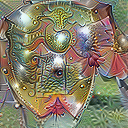

  0%|          | 0/512 [00:00<?, ?it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  0%|          | 2/512 [00:00<00:57,  8.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  1%|          | 6/512 [00:00<00:25, 20.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  2%|▏         | 10/512 [00:00<00:19, 26.40it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  3%|▎         | 14/512 [00:00<00:16, 29.94it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▎         | 18/512 [00:00<00:15, 32.24it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  4%|▍         | 22/512 [00:00<00:14, 33.56it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  5%|▌         | 26/512 [00:00<00:14, 34.39it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  6%|▌         | 30/512 [00:01<00:13, 35.15it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 34/512 [00:01<00:13, 35.62it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  7%|▋         | 38/512 [00:01<00:13, 35.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  8%|▊         | 42/512 [00:01<00:13, 36.05it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


  9%|▉         | 46/512 [00:01<00:12, 35.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 10%|▉         | 50/512 [00:01<00:14, 31.47it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 11%|█         | 54/512 [00:01<00:14, 31.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 11%|█▏        | 58/512 [00:01<00:13, 32.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 12%|█▏        | 62/512 [00:01<00:13, 33.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 13%|█▎        | 66/512 [00:02<00:12, 34.44it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 14%|█▎        | 70/512 [00:02<00:12, 35.03it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 14%|█▍        | 74/512 [00:02<00:12, 35.54it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 15%|█▌        | 78/512 [00:02<00:12, 35.74it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 16%|█▌        | 82/512 [00:02<00:11, 36.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 17%|█▋        | 86/512 [00:02<00:11, 35.86it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 18%|█▊        | 90/512 [00:02<00:12, 35.16it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 18%|█▊        | 94/512 [00:02<00:12, 34.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 19%|█▉        | 98/512 [00:02<00:12, 34.02it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 20%|█▉        | 102/512 [00:03<00:11, 34.53it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 21%|██        | 106/512 [00:03<00:11, 34.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 21%|██▏       | 110/512 [00:03<00:11, 33.58it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 22%|██▏       | 114/512 [00:03<00:11, 33.30it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 23%|██▎       | 118/512 [00:03<00:12, 32.03it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 24%|██▍       | 122/512 [00:03<00:12, 31.20it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 25%|██▍       | 126/512 [00:03<00:12, 30.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 25%|██▌       | 130/512 [00:04<00:12, 29.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 26%|██▌       | 133/512 [00:04<00:12, 29.58it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 27%|██▋       | 136/512 [00:04<00:12, 29.57it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 28%|██▊       | 144/512 [00:04<00:11, 31.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 29%|██▉       | 148/512 [00:04<00:11, 32.83it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 30%|██▉       | 152/512 [00:04<00:10, 33.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 30%|███       | 156/512 [00:04<00:10, 33.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 31%|███▏      | 160/512 [00:04<00:10, 34.45it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 32%|███▏      | 164/512 [00:05<00:10, 34.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 33%|███▎      | 168/512 [00:05<00:09, 34.51it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 34%|███▎      | 172/512 [00:05<00:09, 34.70it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 34%|███▍      | 176/512 [00:05<00:09, 34.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 35%|███▌      | 180/512 [00:05<00:09, 35.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 36%|███▌      | 184/512 [00:05<00:09, 35.26it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 37%|███▋      | 188/512 [00:05<00:09, 35.63it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 38%|███▊      | 192/512 [00:05<00:08, 35.62it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 38%|███▊      | 196/512 [00:05<00:08, 35.82it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 39%|███▉      | 200/512 [00:06<00:08, 34.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 40%|███▉      | 204/512 [00:06<00:08, 35.10it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 41%|████      | 208/512 [00:06<00:09, 33.55it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 41%|████▏     | 212/512 [00:06<00:18, 16.49it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 42%|████▏     | 215/512 [00:07<00:32,  9.08it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 42%|████▏     | 217/512 [00:08<00:40,  7.27it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 43%|████▎     | 219/512 [00:08<00:48,  6.05it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 43%|████▎     | 222/512 [00:09<00:56,  5.14it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▎     | 223/512 [00:09<01:00,  4.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▍     | 224/512 [00:09<01:03,  4.52it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▍     | 225/512 [00:10<01:05,  4.36it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 44%|████▍     | 226/512 [00:10<01:08,  4.17it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▍     | 228/512 [00:10<01:09,  4.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▍     | 229/512 [00:11<01:11,  3.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▍     | 230/512 [00:11<01:10,  3.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 45%|████▌     | 231/512 [00:11<01:11,  3.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 233/512 [00:12<01:09,  4.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▌     | 235/512 [00:12<01:09,  3.99it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▋     | 237/512 [00:13<01:08,  4.03it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 46%|████▋     | 238/512 [00:13<01:10,  3.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 47%|████▋     | 241/512 [00:14<00:48,  5.58it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 244/512 [00:14<00:37,  7.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 246/512 [00:14<00:33,  8.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 48%|████▊     | 248/512 [00:14<00:31,  8.29it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 250/512 [00:15<00:30,  8.53it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 49%|████▉     | 251/512 [00:15<00:29,  8.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 51%|█████     | 259/512 [00:15<00:11, 21.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 52%|█████▏    | 267/512 [00:15<00:08, 28.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 54%|█████▎    | 275/512 [00:15<00:07, 32.31it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 55%|█████▌    | 283/512 [00:16<00:06, 34.18it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 57%|█████▋    | 291/512 [00:16<00:06, 34.84it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 58%|█████▊    | 299/512 [00:16<00:05, 35.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 60%|█████▉    | 307/512 [00:16<00:05, 36.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 62%|██████▏   | 315/512 [00:16<00:05, 35.90it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 63%|██████▎   | 323/512 [00:17<00:05, 36.25it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 65%|██████▍   | 331/512 [00:17<00:05, 35.41it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 66%|██████▌   | 339/512 [00:17<00:04, 35.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 68%|██████▊   | 347/512 [00:17<00:04, 36.18it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 69%|██████▉   | 355/512 [00:18<00:04, 35.98it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 71%|███████   | 363/512 [00:18<00:04, 35.96it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 72%|███████▏  | 371/512 [00:18<00:03, 35.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 74%|███████▍  | 379/512 [00:18<00:03, 36.01it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 76%|███████▌  | 387/512 [00:18<00:03, 35.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 77%|███████▋  | 395/512 [00:19<00:03, 36.11it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 79%|███████▊  | 403/512 [00:19<00:03, 36.13it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 80%|████████  | 411/512 [00:19<00:02, 36.28it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 82%|████████▏ | 419/512 [00:19<00:02, 35.84it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 83%|████████▎ | 427/512 [00:20<00:02, 35.80it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 85%|████████▍ | 435/512 [00:20<00:02, 35.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 87%|████████▋ | 443/512 [00:20<00:01, 35.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 88%|████████▊ | 451/512 [00:20<00:01, 36.07it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 90%|████████▉ | 459/512 [00:20<00:01, 36.06it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 91%|█████████ | 467/512 [00:21<00:01, 34.93it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 92%|█████████▏| 471/512 [00:21<00:02, 16.59it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 474/512 [00:22<00:04,  9.24it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 476/512 [00:22<00:04,  7.34it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 93%|█████████▎| 478/512 [00:23<00:05,  6.22it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 480/512 [00:24<00:05,  5.40it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 481/512 [00:24<00:06,  5.12it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 94%|█████████▍| 482/512 [00:24<00:06,  4.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▍| 484/512 [00:25<00:06,  4.45it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▍| 486/512 [00:25<00:06,  4.23it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 95%|█████████▌| 487/512 [00:25<00:06,  4.03it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 489/512 [00:26<00:05,  3.97it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 490/512 [00:26<00:05,  3.89it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 491/512 [00:26<00:05,  3.87it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▌| 492/512 [00:27<00:05,  3.88it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▋| 493/512 [00:27<00:05,  3.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 96%|█████████▋| 494/512 [00:27<00:04,  3.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 495/512 [00:27<00:04,  3.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 496/512 [00:28<00:04,  3.61it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 97%|█████████▋| 498/512 [00:28<00:03,  3.95it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 500/512 [00:28<00:02,  5.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 98%|█████████▊| 504/512 [00:29<00:01,  7.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 506/512 [00:29<00:00,  8.27it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 508/512 [00:29<00:00,  8.61it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


 99%|█████████▉| 509/512 [00:29<00:00,  8.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]


100%|██████████| 512/512 [00:30<00:00, 17.02it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]



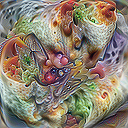

In [46]:
#save_multiple_visualizations(dir_path=dir_path,
#                             model=model,
#                             model_name="inception-v3-offset-100",
#                             viz_indices=[f"lyr_3:{x}" for x in range(0, 1000, 100)])
save_multiple_visualizations(dir_path=dir_path,
                             model=model,
                             model_name="inception-v3-offset-100",
                             viz_indices=[f"softmax2_pre_activation_matmul:{x}" for x in range(0, 1000, 100)])

## Figure: original-visualizations

In [47]:
from lucent.modelzoo.inceptionv1.InceptionV1 import InceptionV1 as INCEPTION_V1
model = INCEPTION_V1(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device).eval();

In [48]:
dir_path = os.path.join(PROJECT_DIR, 'data/original-visualizations/')

 46%|████▌     | 236/512 [00:06<00:07, 36.67it/s]

100%|██████████| 512/512 [00:22<00:00, 22.85it/s]



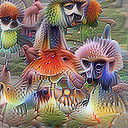

100%|██████████| 512/512 [00:29<00:00, 17.48it/s]



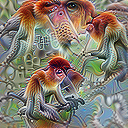

100%|██████████| 512/512 [00:29<00:00, 17.30it/s]



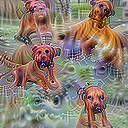

100%|██████████| 512/512 [00:29<00:00, 17.20it/s]



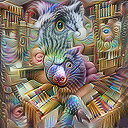

100%|██████████| 512/512 [00:29<00:00, 17.32it/s]



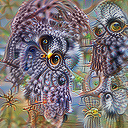

100%|██████████| 512/512 [00:29<00:00, 17.52it/s]



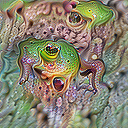

100%|██████████| 512/512 [00:30<00:00, 17.01it/s]



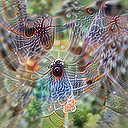

100%|██████████| 512/512 [00:30<00:00, 16.58it/s]



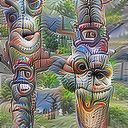

100%|██████████| 512/512 [00:32<00:00, 15.98it/s]



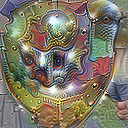

100%|██████████| 512/512 [00:26<00:00, 19.28it/s]



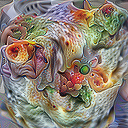

In [49]:
save_multiple_visualizations(dir_path=dir_path,
                             model=model,
                             model_name="inception-v1",
                             viz_indices=[f"softmax2_pre_activation_matmul:{x}" for x in range(0, 1000, 100)])

## Figure: manually-specified-visualizations

In [50]:
from lucent.modelzoo.inceptionv1.InceptionV4 import InceptionV4 as INCEPTION_V4
model = INCEPTION_V4(pretrained=True, add_custom_layers=True,
                     use_RELU_in_custom_layers=True, verbose=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device).eval();
assert type(model.classifier) is not None

In [51]:
load_classifier_weights(model)

<All keys matched successfully>


In [52]:
manually_specify_visualization_weights(model)

Loaded image of shape (3, 224, 224) with min 0.0 and max 0.996078431372549.
(3, 224, 224)


In [53]:
# make sure classifier predicts natural images for natural images
#_ = model(torch.Tensor(load_image_batch(transform=lambda x: x-117.0)).cuda())

In [54]:
dir_path = os.path.join(PROJECT_DIR, 'data/manually-specified-visualizations/')

Loaded image of shape (3, 224, 224) with min 0.0 and max 0.996078431372549.
(3, 224, 224)


  0%|          | 0/32 [00:00<?, ?it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[10.485574]]


  3%|▎         | 1/32 [00:00<00:08,  3.60it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[8.3296795]]


  6%|▋         | 2/32 [00:00<00:08,  3.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[10.181315]]


  9%|▉         | 3/32 [00:00<00:07,  3.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[9.604878]]


 12%|█▎        | 4/32 [00:01<00:07,  3.66it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[9.147238]]


 16%|█▌        | 5/32 [00:01<00:07,  3.71it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[8.918242]]


 19%|█▉        | 6/32 [00:01<00:06,  3.72it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[8.773057]]


 22%|██▏       | 7/32 [00:01<00:06,  3.67it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[8.807867]]


 25%|██▌       | 8/32 [00:02<00:06,  3.73it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[7.2239084]]


 28%|██▊       | 9/32 [00:02<00:06,  3.81it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[8.371015]]


 31%|███▏      | 10/32 [00:02<00:05,  3.77it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[8.520395]]


 38%|███▊      | 12/32 [00:03<00:05,  3.85it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[7.2132854]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[7.934626]]


 41%|████      | 13/32 [00:03<00:05,  3.76it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[7.875161]]


 47%|████▋     | 15/32 [00:04<00:04,  3.79it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[7.8574047]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[7.35356]]


 50%|█████     | 16/32 [00:04<00:04,  3.64it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[2.3934252]]


 53%|█████▎    | 17/32 [00:04<00:03,  3.75it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[7.7282863]]


 59%|█████▉    | 19/32 [00:04<00:02,  4.38it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[7.1413713]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[7.5458994]]


 66%|██████▌   | 21/32 [00:05<00:01,  5.78it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[8.29164]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[5.6021304]]


 75%|███████▌  | 24/32 [00:05<00:01,  7.40it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[7.400321]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[7.7820735]]


 81%|████████▏ | 26/32 [00:05<00:00,  8.04it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[4.7319403]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[6.215335]]


 88%|████████▊ | 28/32 [00:05<00:00,  8.50it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[5.9510336]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[5.6312804]]


 91%|█████████ | 29/32 [00:06<00:00,  8.65it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[2.8384526]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[6.7412286]]


100%|██████████| 32/32 [00:06<00:00,  5.09it/s]

classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[8.243758]]
classifier prediction: [[1.]] (0: fv, 1: nat) --- sigmoid: [[0.7068648]] --- inverted: [[0.]]
visualization layer output: [[6.9613404]]



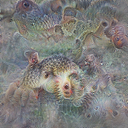

In [55]:
#num_imgs = 12
#for i in range(num_imgs):
#    manually_specify_visualization_weights(model, target_img_idx=i)
#    save_multiple_visualizations(dir_path=dir_path,
#                                 model=model,
#                                 model_name=f"inception-v4-img-{i}",
#                                 viz_indices=["lyr_3:0"],
#                                 thresholds=(2,4,6,8,10,12,14,16,20,32))
manually_specify_visualization_weights(model)
save_multiple_visualizations(dir_path=dir_path,
                             model=model,
                             model_name=f"inception-v4-img-0",
                             viz_indices=["lyr_3:0"],
                             thresholds=(2,4,6,8,10,12,14,16,20,32))

## Figure: silent-units

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from lucent.modelzoo import resnet50
model = resnet50(pretrained=True)
model.to(device).eval();

/home/carlyn.1/miniconda3/envs/fooling/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/carlyn.1/miniconda3/envs/fooling/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
dir_path = os.path.join(PROJECT_DIR, 'data/silent-units-layer3-1-conv3/')

  0%|          | 0/512 [00:00<?, ?it/s]

100%|██████████| 512/512 [00:11<00:00, 44.98it/s]



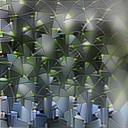

100%|██████████| 512/512 [00:09<00:00, 54.99it/s]



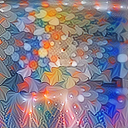

100%|██████████| 512/512 [00:13<00:00, 38.89it/s]



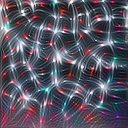

100%|██████████| 512/512 [00:13<00:00, 37.87it/s]



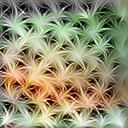

100%|██████████| 512/512 [00:13<00:00, 38.09it/s]



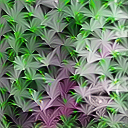

100%|██████████| 512/512 [00:14<00:00, 36.29it/s]



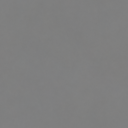

100%|██████████| 512/512 [00:13<00:00, 38.33it/s]



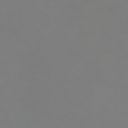

100%|██████████| 512/512 [00:13<00:00, 38.03it/s]



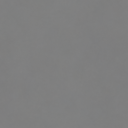

100%|██████████| 512/512 [00:13<00:00, 37.90it/s]



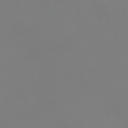

100%|██████████| 512/512 [00:13<00:00, 38.28it/s]



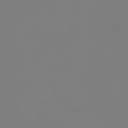

In [58]:
# silent units
for layer in ["layer3_1_conv3", "layer3_1_bn3"]:
    save_multiple_visualizations(dir_path=dir_path,
                                 model=model,
                                 model_name="ResNet-50",
                                 viz_indices=[f"{layer}:{idx}" for idx in [147, 316, 342, 405, 750]],
                                 thresholds=(512,))

  1%|▏         | 7/512 [00:00<00:07, 66.85it/s]

100%|██████████| 512/512 [00:13<00:00, 38.08it/s]



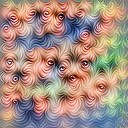

100%|██████████| 512/512 [00:13<00:00, 38.21it/s]



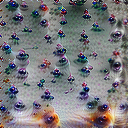

100%|██████████| 512/512 [00:13<00:00, 38.13it/s]



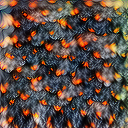

100%|██████████| 512/512 [00:13<00:00, 37.59it/s]



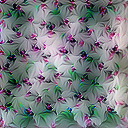

100%|██████████| 512/512 [00:13<00:00, 37.31it/s]



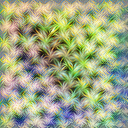

100%|██████████| 512/512 [00:13<00:00, 37.52it/s]



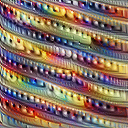

100%|██████████| 512/512 [00:13<00:00, 37.73it/s]



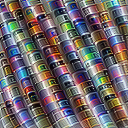

100%|██████████| 512/512 [00:13<00:00, 37.11it/s]



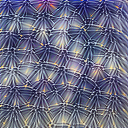

100%|██████████| 512/512 [00:13<00:00, 37.70it/s]



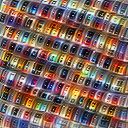

100%|██████████| 512/512 [00:13<00:00, 37.43it/s]



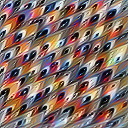

In [59]:
# non-silent units
for layer in ["layer3_1_conv3", "layer3_1_bn3"]:
    save_multiple_visualizations(dir_path=dir_path,
                                    model=model,
                                    model_name="ResNet-50",
                                    viz_indices=[f"{layer}:{idx}" for idx in [172, 184, 324, 581, 968]],
                                    thresholds=(512,))